# Housing Price Prediction using Caffe2

Note: this tutorial is created based on the `https://caffe2.ai/docs/tutorial-toy-regression.html`. For more detailed explaination, please find more information from `https://caffe2.ai/docs/`. 

In this tutorial, we will get familar with the building block to train a model using Caffe2, in particularly, we will go through solving housing price prediction problem using Caffe2.

1. Representing a linear regression using computational graph

2. Create a network with this data

3. Train a linear regression model using Caffe2

4. Tweak the hyper-parameters for this network based on the results

5. Apply the network to the real-world data

The following code is to load the package depedencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.preprocessing import PolynomialFeatures
import time
from IPython import display


from caffe2.python import core, cnn, net_drawer, workspace, visualize, brew, optimizer
from caffe2.python.model_helper import ModelHelper
from caffe2.proto import caffe2_pb2

%matplotlib inline

We first specify the input parameters of the regression model
1. number of samples in the input data
2. num of training iterations
3. learning rate of Stochastic Gradient Descent algorithm
4. the initial weights of the model

In [2]:
num_samples=200
learning_rate=0.05
training_iters=100
initial_weights=[0.]

We then create the dataset from sklearn

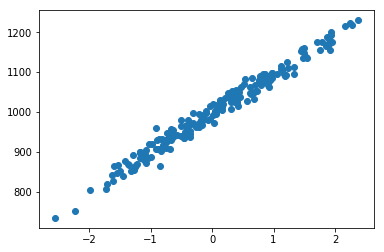

In [3]:
# generate regression dataset
X, Y_gt = sklearn.datasets.make_regression(n_samples=num_samples,n_features=1,
                                n_informative=1,noise=15,
                                bias=1000,random_state=0)
Y_gt = np.reshape(Y_gt,(-1,1))
# plot regression dataset
plt.scatter(X,Y_gt)
plt.show()

In [4]:
print (X.shape)
print (Y_gt.shape)

(200, 1)
(200, 1)


Create the model helper object we will use to create the regression model

#### # Representing a linear regression using computational graph

Here is how we represent a linear regression model using computational graph, and how we create such a linear regression model in Caffe2.

We use a 'FC' layer as the main component of the model. Since we desire one weight ($\beta_1$), we set our input dimension to 1. Because we only expect a single result, the output dimension will be 1. Note that we imply a bias when using an 'FC' layer, and we refer this as $\beta_0$.

Before continuing, let's take a look at the protobuf created in this step. 

The first print out is of the 'net', which contains the details about the architecture of a linear regression model.

There is a single 'op' in the network that expects an input $X$, a weight and bias, and outputs $y_{pred}$. 

In the print out of the 'param_init_net,' we see that this is where the initializations for the weights and biases exist. This is an important observation that gives insight into how a model in Caffe2 is constructed and maintained.

In [11]:
regression_model = ModelHelper(name="regression_model")
# Add the FC layer, which is the main component of a linear regression model
y_pred = brew.fc(regression_model,'X','y_pred', dim_in=1, dim_out=1)

# Print the predict and init net to see what protobuf was created for this model
print("************* Predict Net *************")
print(regression_model.net.Proto())
print("\n************* Init Net *************")
print(regression_model.param_init_net.Proto())

************* Predict Net *************
name: "regression_model_1"
op {
  input: "X"
  input: "y_pred_w"
  input: "y_pred_b"
  output: "y_pred"
  name: ""
  type: "FC"
  arg {
    name: "use_cudnn"
    i: 1
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
}
external_input: "X"
external_input: "y_pred_w"
external_input: "y_pred_b"


************* Init Net *************
name: "regression_model_init_1"
op {
  output: "y_pred_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 1
    ints: 1
  }
}
op {
  output: "y_pred_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 1
  }
}



# Define the loss function
We also define the loss function by a squared L2 distance, but feel free to replace the loss function with others.

We use SGD optimization, and we set our learningr_rate.

We use workspace.FeedBlob to load the ground truth data and input data.

We also inject the initial weights and bias.

The loss function is computed by a squared L2 distance, and then averaged over all items.

In [12]:
dist = regression_model.SquaredL2Distance(['Y_gt', y_pred], "dist")
loss = regression_model.AveragedLoss(dist, "loss")

# Define the SGD optimization and visualize the graph

Once we get the gradients for the parameters, we will add the SGD part of the graph: get the learning rate of the current step, and then do parameter updates.

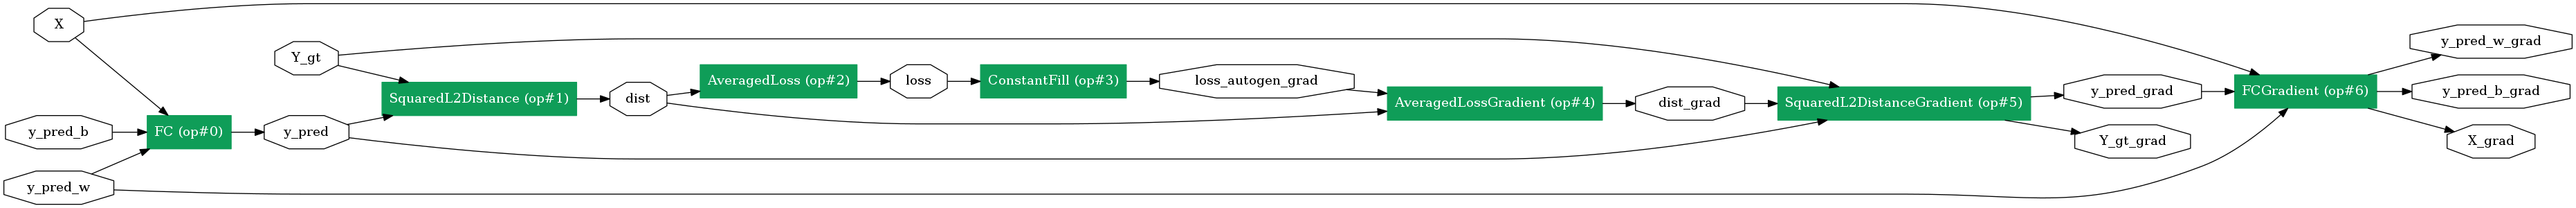

In [13]:
gradient_map=regression_model.AddGradientOperators([loss])
graph = net_drawer.GetPydotGraph(regression_model.Proto().op, "train", rankdir="LR")
display.Image(graph.create_png(), width=800)

In [14]:
optimizer.build_sgd(regression_model, base_learning_rate=learning_rate)

In [15]:
# Prime the workspace with some data
workspace.FeedBlob("Y_gt",Y_gt.astype(np.float32))
workspace.FeedBlob("X",X.astype(np.float32))

# Run the init net to prepare the workspace then create the net
workspace.RunNetOnce(regression_model.param_init_net)
workspace.CreateNet(regression_model.net)

# Inject our desired initial weights and bias
workspace.FeedBlob("y_pred_w",np.array([initial_weights]).astype(np.float32))
workspace.FeedBlob("y_pred_b",np.array([0.]).astype(np.float32))


True

# Training

In [16]:
# #### Run the training
# Run the training for training_iters
for i in range(training_iters):
    workspace.RunNet(regression_model.net)

print("Training Complete")

Training Complete


# Check the results

Now that our model is trained, we can pull out the learned weights and biases which exist as blobs in the workspace named 'y_pred_w' and 'y_pred_b.'

Extract the learned coes and intercept from the workspace

In [17]:
coes = workspace.FetchBlob("y_pred_w")[0]
intercept = workspace.FetchBlob("y_pred_b")

Calculate the regression line for plotting

In [18]:
x_vals = np.linspace(X.min(), X.max(),100)
regression_result = intercept[0] + coes[0]*x_vals
print("Best Fit Line: {}*x + {}".format(round(coes[0],5), round(intercept[0],5)))

Best Fit Line: 98.11667*x + 991.81122


Plot the results of the regression

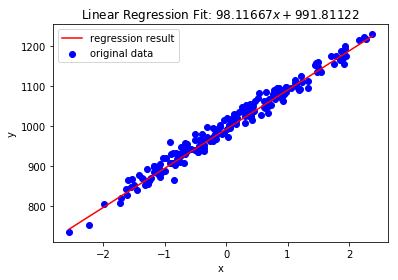

In [19]:
plt.scatter([i[0] for i in X],Y_gt,label="original data",color='b')
plt.plot(x_vals,regression_result,label="regression result",color='r')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression Fit: ${{{}}}x + {{{}}}$".format(round(coes[0],5), round(intercept[0],5)))
plt.show()

The above example shows you how to create a linear regression model that is easily adapted to handle higher order polynomials. Now, we will consider the baseline case where we desire a simple first order model, with 1-D input $x,$ 1-D output $y,$ and a solution of the form:

$$y = \beta_1x + \beta_0$$

# Examples for 2nd-order polynomial dataset

In [114]:
# Number of training sample to generate
num_samples = 200
# Learning Rate of SGD algorithm
learning_rate = .05
# Number of iterations to train
training_iters = 100
# Initial model weights
initial_weights = [0.,0.]

### Create and Prepare the Dataset
Now, we will create and prepare the dataset for use with the model. Note, we are just constructing numpy arrays here. Any other data can be used as long as it is shaped properly before being input into the model.


X Sample:
[[-1.36362855  1.85948283]
 [-1.43814136  2.06825056]
 [ 0.40491547  0.16395654]
 [ 0.78949344  0.62329988]
 [-1.36551371  1.8646277 ]]
Y Sample:
[[2.43703684]
 [2.89202826]
 [0.25183677]
 [1.56180245]
 [2.85026983]]


Text(0.5,1,u'Input Training Data')

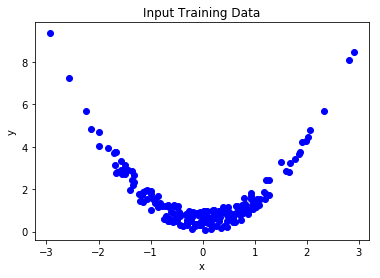

In [21]:
# Create the original observations
orig_X,_ = sklearn.datasets.make_regression(n_samples=num_samples,n_features=1,noise=5)
poly = PolynomialFeatures(degree=2, include_bias=False)
# Transform the features into second order polynomial features
xx_ = poly.fit_transform(orig_X)

# Extract the predictors and the values from the manufactured data
X = [i[0] for i in xx_]
Y_gt = [i[1] for i in xx_]
noise = np.random.uniform(size=(len(Y_gt)))
# Add some noise to the ground truth values
Y_gt += noise

# Shape the ground truth values for use with the model
Y_gt = np.reshape(Y_gt,(-1,1))
# Format the input features. Recall, we accomplish polynomial regression by
#   including the original and the polynomial version of the predictors
#   as features of the model
X = np.hstack((np.array(X).reshape(-1,1),np.array(X).reshape(-1,1)**2))

# Print a sample of the input data. X is the list of 2-feature input observations 
#   and Y is the list of ground truth values associated with each observation
print("X Sample:\n{}".format(X[:5]))
print("Y Sample:\n{}".format(Y_gt[:5]))

# Plot the input data
plt.scatter([i[0] for i in X],Y_gt,label="original data",color='b')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Input Training Data")

### Create the Model
Define the model architecture
With our training data created and our second order polynomial assumption stated, we can now create a model to learn the regression line. We will use a 'FC' layer as the main component of the model. Since we desire two weights ($\beta_2$ and $\beta_1$), we set our input dimension to 2, and since we only expect a single quantitative result, our output dimension is 1. Note, when using an 'FC' layer it is implied that there is a bias, which we will use as our $\beta_0.$

Also, before continuing take a look at the protobuf created in this step. The first print out is of the 'net,' and contains the architecture of the model. At a glance, we see that as expected, there is a single op in the network that expects an input $X,$ a weight and bias, and outputs $y_{pred}.$ In the print out of the 'param_init_net,' we see that this is where the initializations for the weights and biases exist. This is an important observation that gives insight into how a model in Caffe2 is constructed and maintained.


In [23]:
# Create the model helper object we will use to create the regression model
regression_model = ModelHelper(name="regression_model")

# Add the FC layer, which is the main component of a linear regression model
y_pred = brew.fc(regression_model,'X','y_pred', dim_in=2, dim_out=1)

# Print the predict and init net to see what protobuf was created for this model
print("************* Predict Net *************")
print(regression_model.net.Proto())
print("\n************* Init Net *************")
print(regression_model.param_init_net.Proto())


************* Predict Net *************
name: "regression_model"
op {
  input: "X"
  input: "y_pred_w"
  input: "y_pred_b"
  output: "y_pred"
  name: ""
  type: "FC"
  arg {
    name: "use_cudnn"
    i: 1
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
}
external_input: "X"
external_input: "y_pred_w"
external_input: "y_pred_b"


************* Init Net *************
name: "regression_model_init"
op {
  output: "y_pred_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 1
    ints: 2
  }
}
op {
  output: "y_pred_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 1
  }
}



### Add the training operators and prime the workspace
In this **very important** step, we specify the loss function, setup the SGD training algorithm, prime and initialize the workspace, and initialize our model's weights and biases.


In [24]:
# The loss function is computed by a squared L2 distance, 
#   and then averaged over all items.
dist = regression_model.SquaredL2Distance(['Y_gt', y_pred], "dist")
loss = regression_model.AveragedLoss(dist, "loss")

# Add the gradient operators and setup the SGD algorithm
regression_model.AddGradientOperators([loss])
optimizer.build_sgd(regression_model, base_learning_rate=learning_rate)

# Prime the workspace with some data
workspace.FeedBlob("Y_gt",Y_gt.astype(np.float32))
workspace.FeedBlob("X",X.astype(np.float32))

# Run the init net to prepare the workspace then create the net
workspace.RunNetOnce(regression_model.param_init_net)
workspace.CreateNet(regression_model.net)

# Inject our desired initial weights and bias
workspace.FeedBlob("y_pred_w",np.array([initial_weights]).astype(np.float32))
workspace.FeedBlob("y_pred_b",np.array([0.]).astype(np.float32))

True

### Run the training

In [25]:
# Run the training for training_iters
for i in range(training_iters):
    workspace.RunNet(regression_model.net)

print("Training Complete")

Training Complete


### Extract Results
Now that our model is trained, we can pull out the learned weights and biases which exist as blobs in the workspace named 'y_pred_w' and 'y_pred_b.'

Best Fit Line: 0.9746*x^2 + -0.05343*x + 0.53541


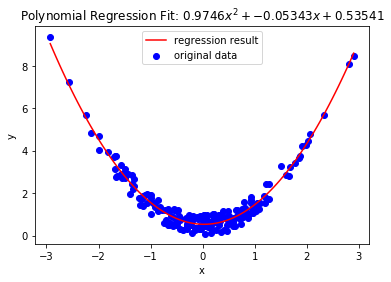

In [26]:
# Extract the learned coes and intercept from the workspace
coes = workspace.FetchBlob("y_pred_w")[0]
intercept = workspace.FetchBlob("y_pred_b")

# Calculate the regression line for plotting
x_vals = np.linspace(orig_X.min(), orig_X.max(),100)
regression_result = intercept[0] + coes[0]*x_vals + coes[1]*(x_vals**2)
print("Best Fit Line: {}*x^2 + {}*x + {}".format(round(coes[1],5), round(coes[0],5), round(intercept[0],5)))

# Plot the results of the regression
plt.scatter([i[0] for i in X],Y_gt,label="original data",color='b')
plt.plot(x_vals,regression_result,label="regression result",color='r')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Polynomial Regression Fit: ${{{}}}x^2 + {{{}}}x + {{{}}}$".format(round(coes[1],5), round(coes[0],5), round(intercept[0],5)))
plt.show()

# Load the California housing dataset

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0)

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [49]:
housing_df = pd.read_csv('/home/shuaizheng/dataset/housing.csv')
housing_df.head()
housing_df = housing_df.drop('ocean_proximity',axis=1)
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [50]:
print('Shape :',housing_df.shape)
print('Features Data types : \n',housing_df.dtypes)
print('checking if any null values')
print(housing_df.isnull().sum())

Shape : (20640, 9)
Features Data types : 
 longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
dtype: object
checking if any null values
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64


In [51]:
# Null values in total_bedrooms so we will drop them, 
#Its best practice to replace any null values with mean/median.
housing_df = housing_df.dropna(axis=0)
housing_df.shape

(20433, 9)

In [52]:
X = housing_df.drop(['median_house_value'],axis=1)
y = housing_df['median_house_value']
print(X.shape,y.shape)
print(type(X))
print(type(y))

(20433, 8) (20433,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [53]:
reg = linear_model.LinearRegression()

In [54]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2)

In [55]:
print(X_train.shape)
print(X_test.shape)

(16346, 8)
(4087, 8)


In [56]:
reg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:
pred = reg.predict(X_test)

In [58]:
print('Predicted Value :',pred[0])
print('Actual Value :',Y_test.values[0])

Predicted Value : 170521.7757148142
Actual Value : 79000.0


In [59]:
res = pd.DataFrame({'Predicted':pred,'Actual':Y_test})
res = res.reset_index()
res = res.drop(['index'],axis=1)

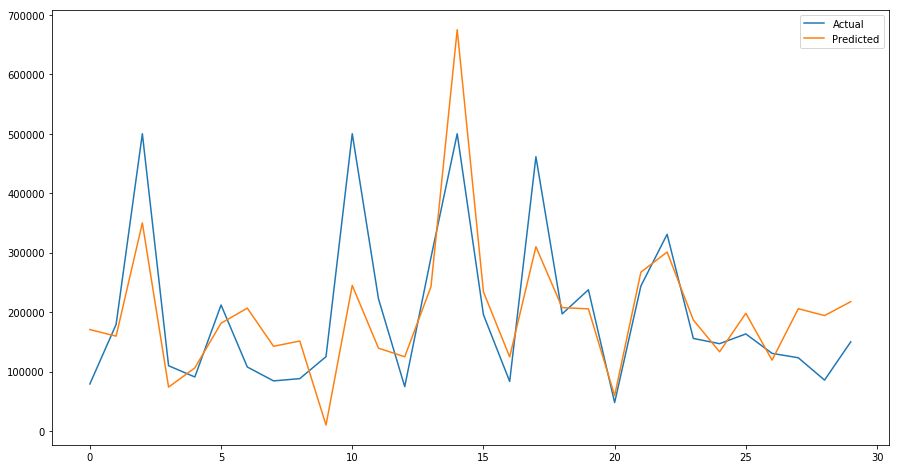

In [60]:
plt.plot(res[:30])
plt.legend(['Actual','Predicted'])

In [77]:
# Extract the predictors and the values from the manufactured data
X = housing_df.drop(['median_house_value'],axis=1)
Y_gt = housing_df['median_house_value']

X = np.array(X)
X = X[:,3:4]
Y_gt = np.array(Y_gt)

In [78]:
print (X.shape)
print (Y_gt.shape)

(20433, 1)
(20433,)


X Sample:
[[ 880.]
 [7099.]
 [1467.]
 [1274.]
 [1627.]]
Y Sample:
[452600. 358500. 352100. 341300. 342200.]


Text(0.5,1,u'Input Training Data')

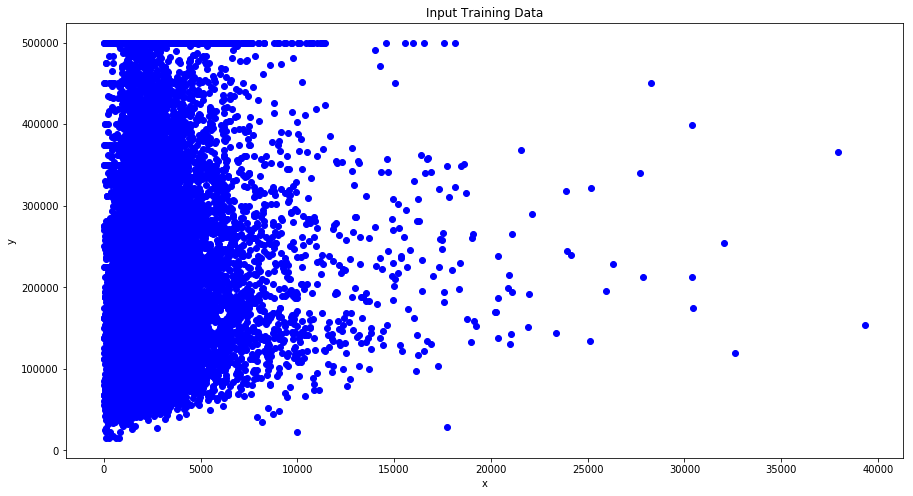

In [79]:
# Print a sample of the input data. X is the list of 2-feature input observations 
#   and Y is the list of ground truth values associated with each observation
print("X Sample:\n{}".format(X[:5]))
print("Y Sample:\n{}".format(Y_gt[:5]))

# Plot the input data
plt.scatter([i[0] for i in X],Y_gt,label="original data",color='b')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Input Training Data")

In [102]:
learning_rate=0.05
training_iters=1000
initial_weights=[0.]

In [103]:
regression_model = ModelHelper(name="regression_model")
# Add the FC layer, which is the main component of a linear regression model
y_pred = brew.fc(regression_model,'X','y_pred', dim_in=1, dim_out=1)

# Print the predict and init net to see what protobuf was created for this model
print("************* Predict Net *************")
print(regression_model.net.Proto())
print("\n************* Init Net *************")
print(regression_model.param_init_net.Proto())

************* Predict Net *************
name: "regression_model_9"
op {
  input: "X"
  input: "y_pred_w"
  input: "y_pred_b"
  output: "y_pred"
  name: ""
  type: "FC"
  arg {
    name: "use_cudnn"
    i: 1
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
}
external_input: "X"
external_input: "y_pred_w"
external_input: "y_pred_b"


************* Init Net *************
name: "regression_model_init_9"
op {
  output: "y_pred_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 1
    ints: 1
  }
}
op {
  output: "y_pred_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 1
  }
}



In [104]:
dist = regression_model.SquaredL2Distance(['Y_gt', y_pred], "dist")
loss = regression_model.AveragedLoss(dist, "loss")
gradient_map=regression_model.AddGradientOperators([loss])
graph = net_drawer.GetPydotGraph(regression_model.Proto().op, "train", rankdir="LR")
#display.Image(graph.create_png(), width=800)
optimizer.build_sgd(regression_model, base_learning_rate=learning_rate)

In [105]:
X_input=np.asarray(X_train)
X_input=X_input[:,7]
X_input=np.reshape(X_input,(-1,1))
Y_gnd  =np.asarray(Y_train)
Y_gnd=np.reshape(Y_gnd,(-1,1))
print (X_input.shape)
print (Y_gnd.shape)

(16346, 1)
(16346, 1)


In [106]:
# Prime the workspace with some data
workspace.FeedBlob("Y_gt",Y_gnd.astype(np.float32))
workspace.FeedBlob("X",X_input.astype(np.float32))

# Run the init net to prepare the workspace then create the net
workspace.RunNetOnce(regression_model.param_init_net)
workspace.CreateNet(regression_model.net)

# Inject our desired initial weights and bias
workspace.FeedBlob("y_pred_w",np.array([initial_weights]).astype(np.float32))
workspace.FeedBlob("y_pred_b",np.array([0.]).astype(np.float32))


True

In [107]:
# #### Run the training
# Run the training for training_iters
for i in range(training_iters):
    workspace.RunNet(regression_model.net)

print("Training Complete")

Training Complete


In [108]:
coes = workspace.FetchBlob("y_pred_w")[0]
intercept = workspace.FetchBlob("y_pred_b")

In [109]:
print (coes)
print (intercept)

[41702.496]
[45514.883]


In [110]:
x_vals = np.linspace(X_input.min(), X_input.max(),100)
regression_result = intercept[0] + coes[0]*x_vals
print("Best Fit Line: {}*x + {}".format(round(coes[0],5), round(intercept[0],5)))

Best Fit Line: 41702.49609*x + 45514.88281


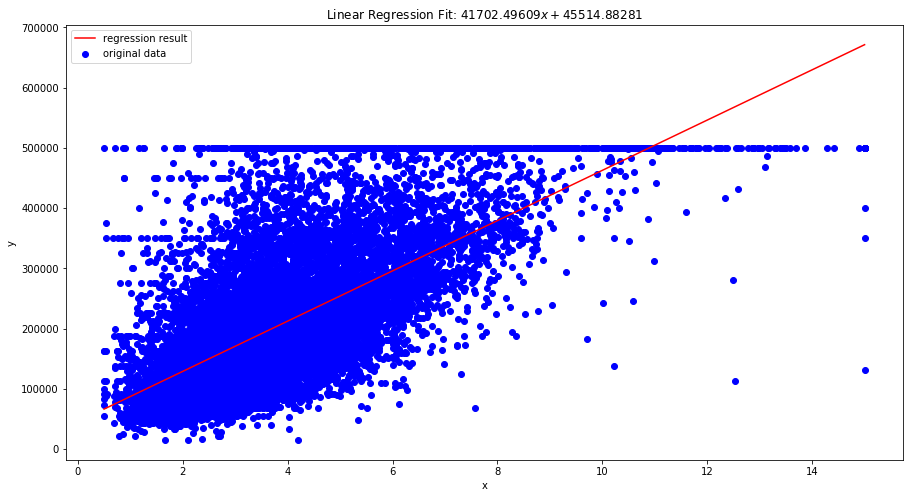

In [112]:
plt.scatter([i[0] for i in X_input],Y_gnd,label="original data",color='b')
plt.plot(x_vals,regression_result,label="regression result",color='r')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression Fit: ${{{}}}x + {{{}}}$".format(round(coes[0],5), round(intercept[0],5)))
plt.show()